In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.linalg as linalg
from scipy.sparse.linalg import eigsh
from tqdm import tqdm

import punct_utils as utils

plt.style.use('default')
plt.rcParams["text.usetex"] = True
np.random.seed(14159)

In [13]:
n = 2000 # sample size
p = 100 # dimension
L = 50 # band size
mu_norm = 2
eS = 0.5

setting = "$n = {} \\quad p = {} \\quad L = {} \\quad \\| \\mu \\| = {} \\quad \\varepsilon_S = {}$".format(n, p, L, mu_norm, eS)

c = p/n
epsilon = (2*L-1)/n

pm1_setting = True

if pm1_setting:
    k = 2 # number of classes
    pi = np.array([0.5, 0.5]) # proportion of each class
    mu = stats.norm.rvs(size=(p, 1))
    M = np.concatenate([+mu, -mu], axis=1)
else:
    k = 3 # number of classes
    pi = np.array([0.34, 0.33, 0.33]) # proportion of each class
    M = stats.norm.rvs(size=(p, k))

M = mu_norm*M/np.linalg.norm(M, axis=0) # centroid of each class
J = utils.getJ(n, pi)
P = M@(J.T)
Z = stats.norm.rvs(size=(p, n))
X = P+Z

S = stats.bernoulli.rvs(eS, size=(p, n))
T = utils.gen_mask(n, L, kind='toeplitz')

K = (X.T@X)/p
KT = K*T
KST = ((X*S).T@(X*S))*T/p

In [14]:
eigvals_k, eigvecs_k = linalg.eigh(K)
eigvals_kt, eigvecs_kt = linalg.eigh(KT)
eigvals_kst, eigvecs_kst = linalg.eigh(KST)

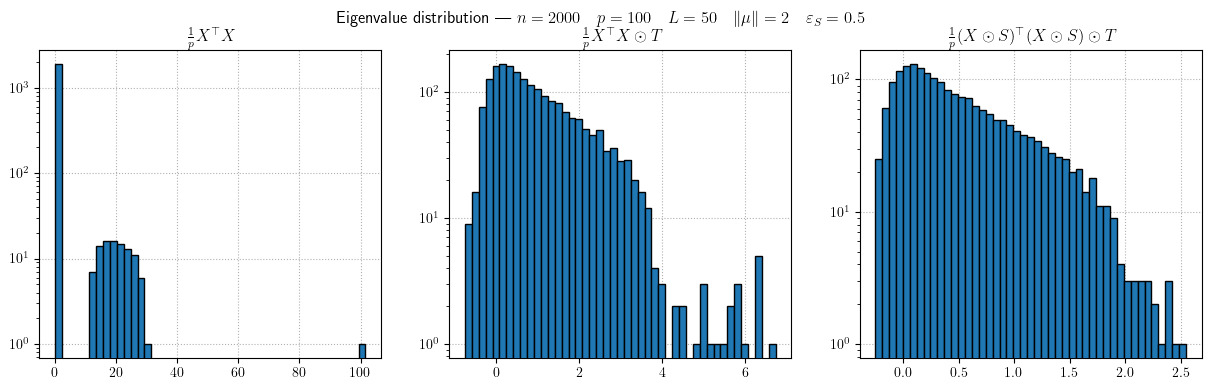

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].hist(eigvals_k, bins='sqrt', edgecolor='black', zorder=3)
ax[1].hist(eigvals_kt, bins='sqrt', edgecolor='black', zorder=3)
ax[2].hist(eigvals_kst, bins='sqrt', edgecolor='black', zorder=3)
ax[0].set_title("$\\frac{1}{p} X^{\\top} X$")
ax[1].set_title("$\\frac{1}{p} X^{\\top} X \\odot T$")
ax[2].set_title("$\\frac{1}{p} (X \\odot S)^{\\top} (X \\odot S) \\odot T$")
for i in range(3):
    ax[i].set_yscale('log')
    ax[i].grid(ls=':')
fig.suptitle("Eigenvalue distribution | "+setting)
plt.show()

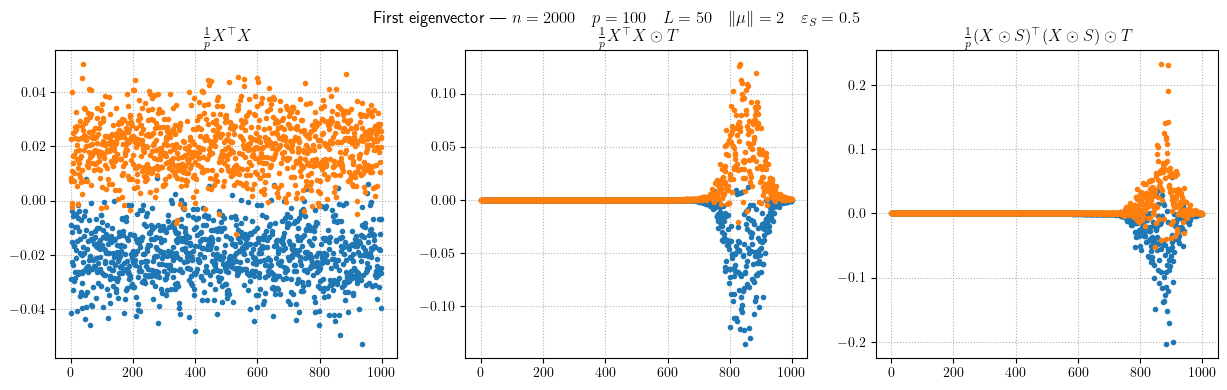

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
for j in range(k):
    ax[0].plot(eigvecs_k[(J[:, j] == 1), -1], ls='', marker='.')
    ax[1].plot(eigvecs_kt[(J[:, j] == 1), -1], ls='', marker='.')
    ax[2].plot(eigvecs_kst[(J[:, j] == 1), -1], ls='', marker='.')
ax[0].set_title("$\\frac{1}{p} X^{\\top} X$")
ax[1].set_title("$\\frac{1}{p} X^{\\top} X \\odot T$")
ax[2].set_title("$\\frac{1}{p} (X \\odot S)^{\\top} (X \\odot S) \\odot T$")
for i in range(3):
    ax[i].grid(ls=':')
fig.suptitle("First eigenvector | "+setting)
plt.show()

# $L$ vs. $\varepsilon_S$ trade-off

In [17]:
mem_size = L*p
eS_r = np.round(np.linspace(0.1, 1, 30), 2)
L_r = np.round(mem_size/(p*eS_r)).astype(int)
top_eigvecs = np.zeros((len(eS_r), n))

In [18]:
for i, (eS, L) in enumerate(zip(tqdm(eS_r), L_r)):
    S = stats.bernoulli.rvs(eS, size=(p, n))
    T = utils.gen_mask(n, L, kind='toeplitz')
    KST = ((X*S).T@(X*S))*T/p
    top_eigvecs[i] = eigsh(KST, which='LA', k=1)[1][:, 0]

100%|██████████| 30/30 [00:07<00:00,  4.11it/s]


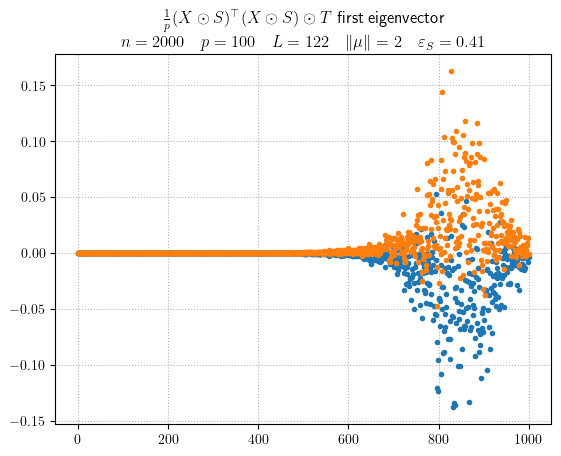

In [19]:
i = 10
for j in range(k):
    plt.plot(top_eigvecs[i, (J[:, j] == 1)], ls='', marker='.')
plt.grid(ls=':')
setting = "$n = {} \\quad p = {} \\quad L = {} \\quad \\| \\mu \\| = {} \\quad \\varepsilon_S = {}$".format(n, p, L_r[i], mu_norm, eS_r[i], 2)
plt.title("$\\frac{1}{p} (X \\odot S)^{\\top} (X \\odot S) \\odot T$ first eigenvector \n"+setting)
plt.show()

In [20]:
true_partition = np.argmax(J, axis=1)
if pm1_setting:
    c_err = np.mean((top_eigvecs > 0) == true_partition, axis=1)
    c_err = np.minimum(c_err, 1-c_err)

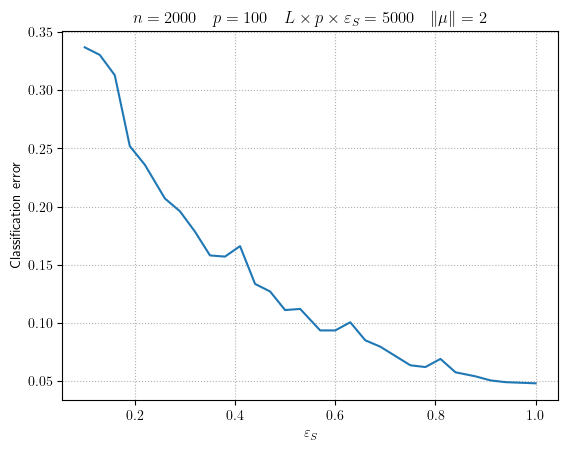

In [21]:
if pm1_setting:
    plt.plot(eS_r, c_err)
    plt.grid(ls=':')
    plt.xlabel("$\\varepsilon_S$")
    plt.ylabel("Classification error")
    plt.title("$n = {} \\quad p = {} \\quad L \\times p \\times \\varepsilon_S = {} \\quad \\| \\mu \\| = {}$".format(n, p, mem_size, mu_norm))